In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt 
from dataloader import InsectDatamodule

In [25]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, n_max_pool: int, **kwargs):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same', **kwargs)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same', **kwargs)
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=n_max_pool, stride=n_max_pool)

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.relu(out) + x
        return self.maxpool(out)


class ResNet(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, n_max_pool: int, n_res_blocks: int, num_classes: int, **kwargs):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding='same', **kwargs)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        self.res_blocks = torch.nn.Sequential(
            *[ResBlock(
                in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, n_max_pool=n_max_pool, **kwargs) for _ in range(n_res_blocks)]
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.convout = torch.nn.Conv2d(in_channels=out_channels, out_channels=num_classes, kernel_size=1, **kwargs)

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # x: (N, C=1, H, W)
        x = x.unsqueeze(1)

        # Run input through a first convolutional layer.
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        # Run input through the residual blocks.
        out = self.res_blocks(out)

        # Run input through the average pooling layer. The output is a tensor of shape (N, C, 1, 1).
        out = self.avgpool(out)

        # Run input through the output convolutional layer. This is the same as a fully connected layer but it works with 4D tensors.
        out = self.convout(out)

        # Flatten the output tensor to have shape (N, C).
        out  = out.flatten(1)

        out = self.softmax(out)

        return out


In [26]:
datamodule = InsectDatamodule(csv_paths=['../data/Cicadidae.csv', '../data/Orthoptera.csv'], batch_size=10, use_mel=False, num_workers=0)

In [27]:
resnet = ResNet(in_channels=1, out_channels=10, kernel_size=3, n_max_pool=3, n_res_blocks=3, num_classes=datamodule.num_classes).cuda()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=0.001, weight_decay=0.0)
cross_entropy = torch.nn.CrossEntropyLoss()

train_losses = []
valid_losses = []

for epoch in tqdm(range(1000), ncols=120):
    for x, y in datamodule.train_dataloader():
        x = x.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        y_hat = resnet(x)
        loss = cross_entropy(y_hat, y.float())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    with torch.no_grad():
        loss_sum = 0.
        num_losses = 0
        for x, y in datamodule.val_dataloader():
            x = x.cuda()
            y = y.cuda()
            y_hat = resnet(x)
            loss = cross_entropy(y_hat, y.float())
            loss_sum += loss.item()
            num_losses += 1

        valid_losses.append(loss_sum / num_losses)

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

  2%|█▊                                                                             | 23/1000 [01:47<1:16:30,  4.70s/it]

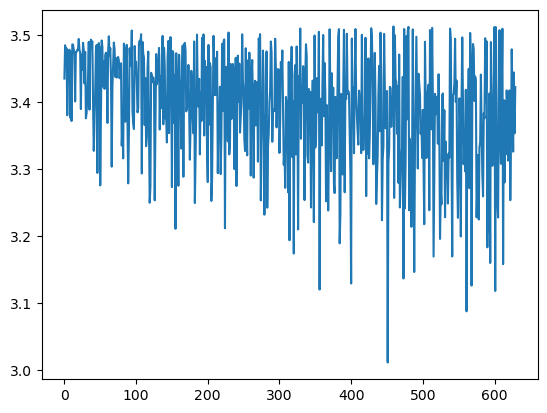

In [21]:
plt.plot(train_losses)

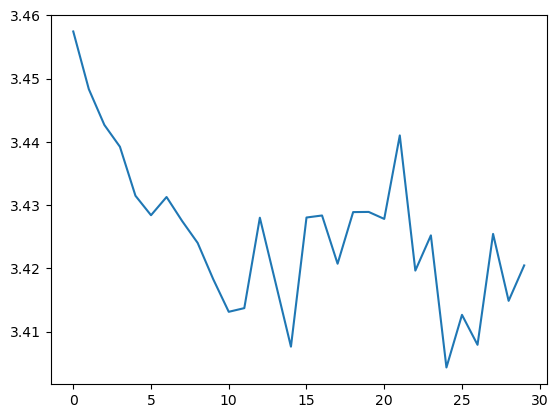

In [22]:
plt.plot(valid_losses)